# Import Data and Packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import matplotlib.pyplot as plt


In [2]:
importdata=pd.read_excel(r'C:\Briana Files\programming\ML AT\KD - mod.xlsx')

#Other data fields are more complete than PV. Since PV is the item we are predicting, let's only look at rows where we are not missing PV. 
idata=importdata.dropna(subset=['PV'])   
idata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434 entries, 14 to 939
Data columns (total 19 columns):
Type                      0 non-null float64
Time                      434 non-null object
Date                      434 non-null datetime64[ns]
Sample Note               363 non-null object
Noted Time                336 non-null object
Sample Time               434 non-null datetime64[ns]
Product                   434 non-null object
CompA                     44 non-null float64
PV                        434 non-null float64
CompF                     44 non-null float64
Unnamed: 10               0 non-null float64
Unnamed: 11               0 non-null float64
Time Start in Kiln        434 non-null datetime64[ns]
Kiln_Gas_Valve            434 non-null object
Kiln Gas Smooth           434 non-null float64
Kiln_Temp_Radia           434 non-null object
Kiln Temp Smooth          434 non-null float64
Kiln Rotation SPD-FDBK    434 non-null object
Kiln Rotation Smooth      434 non-null flo

In [3]:
#Let's create some variables to make referencing column names easier
kiln_temp='Kiln Temp Smooth'
kiln_gas='Kiln Gas Smooth'
kiln_time='Time Start in Kiln'
sample_time='Sample Time'
kiln_rot = 'Kiln Rotation Smooth'
PV= "PV"
CompA = "CompA"
CompF = "CompF"

In [21]:
#values above 200 are most likely due to a poor sample containing too many fines. Let's omit these so as to not adjust our model fit based on such values.
data=idata[idata[PV]<200]

# Data Exploration

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Lab Results Over Time')

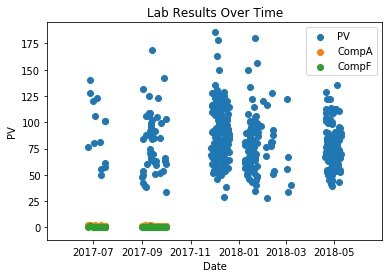

In [5]:
plt.scatter(data[kiln_time],data[PV], label =PV)
plt.scatter(data[kiln_time],data[CompA], label =CompA)
plt.scatter(data[kiln_time],data[CompF], label =CompF)
plt.legend()
plt.xlabel('Date')
plt.ylabel('PV')
plt.title("Lab Results Over Time")



This product is run in campaigns which is where there are gaps between sections. Each run centers around a similar range but there is a difference in variation. 
We only have composition data for two runs, so our models using such data would be limited.  

Let's look at one run in more detail to visually see how control variables might impact PV. 

Text(0, 0.5, 'PV')

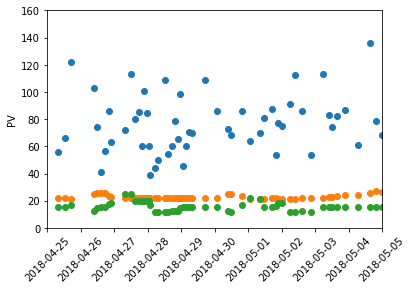

In [6]:
Run_2018_05 = data[data['Date']> '2018-04-15']
plt.scatter(Run_2018_05[kiln_time],Run_2018_05[PV])
plt.scatter(Run_2018_05[kiln_time],Run_2018_05[kiln_gas])
plt.scatter(Run_2018_05[kiln_time],Run_2018_05[kiln_rot])
plt.xlim("2018-04-25","2018-05-05")
plt.xticks(rotation=45)
plt.ylim(0,160)
plt.ylabel('PV')


Text(0.5, 1.0, 'Control Parameters as a Function of PV')

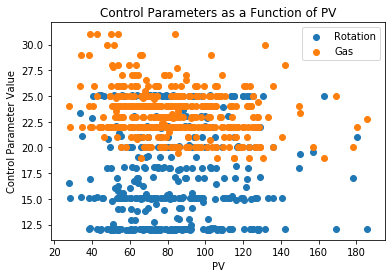

In [7]:
plt.scatter(data[PV],data[kiln_rot], label ="Rotation")
plt.scatter(data[PV],data[kiln_gas], label ="Gas")
plt.legend()
plt.xlabel('PV')
plt.ylabel('Control Parameter Value')
plt.title("Control Parameters as a Function of PV")


y=-0.936292x+(2178.648393)


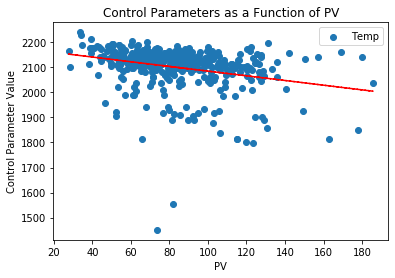

In [8]:
x=data[PV]
y=data[kiln_temp]
plt.scatter(x=x,y=y, label ="Temp")
plt.legend()
plt.xlabel('PV')
plt.ylabel('Control Parameter Value')
plt.title("Control Parameters as a Function of PV")
# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))


The negative correlation between kiln temperature and PV is expected. Thus kiln gas should also be negatively correlated with PV. 
Kiln rotation should be positively correlated to PV. No such relationship is seen which implies that there are other variables that impact PV and rotation has been adjusted in attempt to compensate for these variations in input characteristics. 

# Develop ML models

With the small amount of data available, low-complexity models are preferred as overfitting is a concern. 

Select fields to use as predictors and define predicted output. 

In [9]:
predictors=[kiln_rot,kiln_temp]
X=data[predictors]
y=data[PV]

Split data into train and test sets. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Models will be evaluated based on mean absolute error and correlation coefficient. A dataframe is set up to collect these results and summarize. 

In [11]:
M_summary = pd.DataFrame(columns=['Model','Mean Abs Error',"r2"])
M_summary.set_index("Model")
M_summary.head()

,Model,Mean Abs Error,r2


## Model 1: Median

In [12]:
#Run Model
M1Name = "M1_Median"
M1_train = np.median(y_train)
M1_predict = pd.DataFrame(index=X_test.index)
M1_predict['y predict'] = M1_train

#Assess Fit
M1_MAE = mean_absolute_error(y_test, M1_predict['y predict'] )
M1_r2 = r2_score(y_test, M1_predict['y predict'] )

#Add model stats to summary table
M_summary = M_summary.append({'Model' : M1Name , 'Mean Abs Error' : M1_MAE, "r2": M1_r2} , ignore_index=True)


## Model 2: Decision Tree Regressor
The data is all continuous so regression is used instead of classifiers. 

In [13]:
#Run Model
M2Name = "DT Regressor"
M2_model = DecisionTreeRegressor()
M2_train = M2_model.fit(X_train,y_train)
M2_predict = M2_train.predict(X_test)
#M1_predict['y predict'] =M1_Mean

#Assess Fit
M2_MAE = mean_absolute_error(y_test, M2_predict)
M2_r2 = r2_score(y_test, M2_predict )

#Add model stats to summary table
M2_stats = pd.DataFrame( {'Model' : [M2Name] , 'Mean Abs Error' : [M2_MAE], "r2": [M2_r2]})
M_summary = M_summary.append(M2_stats, ignore_index=True )

## Model 3: Random Forest Regressor

In [14]:
#Run Model
M3Name = "RF Regressor"
M3_model = RandomForestRegressor()
M3_train = M3_model.fit(X_train,y_train)
M3_predict = M3_train.predict(X_test)

#Assess Fit
M3_MAE = mean_absolute_error(y_test, M3_predict)
M3_r2 = r2_score(y_test, M3_predict )

#Add model stats to summary table
M3_stats = pd.DataFrame( {'Model' : [M3Name] , 'Mean Abs Error' : [M3_MAE], "r2": [M3_r2]})
M_summary = M_summary.append(M3_stats, ignore_index=True )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Model 4: KNeighbors Regressor

In [15]:
#Run Model
M4Name = "KNeighbors Regressor"
M4_model = KNeighborsRegressor(n_neighbors=15)
M4_train = M4_model.fit(X_train,y_train)
M4_predict = M4_train.predict(X_test)

#Assess Fit
M4_MAE = mean_absolute_error(y_test, M4_predict)
M4_r2 = r2_score(y_test, M4_predict )

#Add model stats to summary table
M4_stats = pd.DataFrame( {'Model' : [M4Name] , 'Mean Abs Error' : [M4_MAE], "r2": [M4_r2]})
M_summary = M_summary.append(M4_stats, ignore_index=True )

# Model Comparison

In [16]:
M_summary = M_summary.set_index("Model")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA58942160>,
      dtype=object)

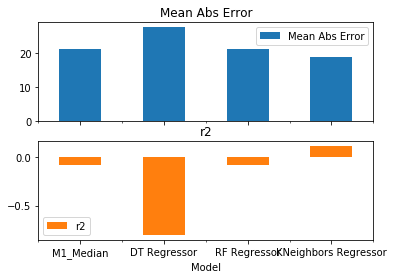

In [17]:
M_summary.plot.bar(rot=0, subplots=True)

Minor difference in square error for each model. 
Some models have a negative correlation and some have a positive correlation. 


In [18]:
#Combine all predicted data sets to compare against actual
predictions = pd.DataFrame(y_test)
predictions[M1Name] = M1_predict
predictions[M2Name] = M2_predict
predictions[M3Name] = M3_predict
predictions[M4Name] = M4_predict
predictions.head()

,PV,M1_Median,DT Regressor,RF Regressor,KNeighbors Regressor
486,49.8,77.4,124.3,83.94,83.986667
610,90.0,77.4,41.0,65.19,64.060000
344,54.0,77.4,53.6,55.84,63.233333
532,63.6,77.4,102.1,93.57,78.766667
74,101.7,77.4,57.8,81.09,86.286667


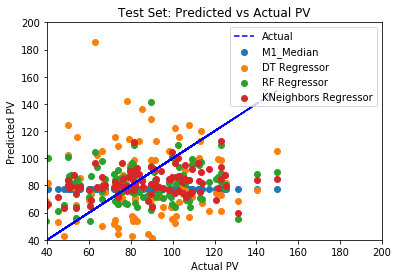

In [20]:
plt.plot(predictions[PV],predictions[PV], "b--", label ="Actual")
plt.scatter(predictions[PV],predictions[M1Name], label =M1Name)
plt.scatter(predictions[PV],predictions[M2Name], label =M2Name)
plt.scatter(predictions[PV],predictions[M3Name], label =M3Name)
plt.scatter(predictions[PV],predictions[M4Name], label =M4Name)
plt.title("Test Set: Predicted vs Actual PV")
plt.xlabel("Actual PV")
plt.ylabel("Predicted PV")
plt.xlim(40,200)
plt.ylim(40,200)
plt.legend()

Some models introduce too much variation in predicted value. KNeighbors is the preferred model with the least MSE and moderate correlation to actual. Model predicts slightly better than median. 